In [133]:
# Setup feedback system
import learntools
from learntools.core import binder
binder.bind(globals())
#from learntools.time_series.ex3 import *

# Setup notebook
from pathlib import Path
#from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [134]:


store_sales = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
)

average_2017_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017', ['sales', 'onpromotion']]
)

C:\Users\Anonymous\AppData\Local\Temp\ipykernel_3704\3967849668.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


AttributeError: 'DataFrame' object has no attribute 'to_frame'

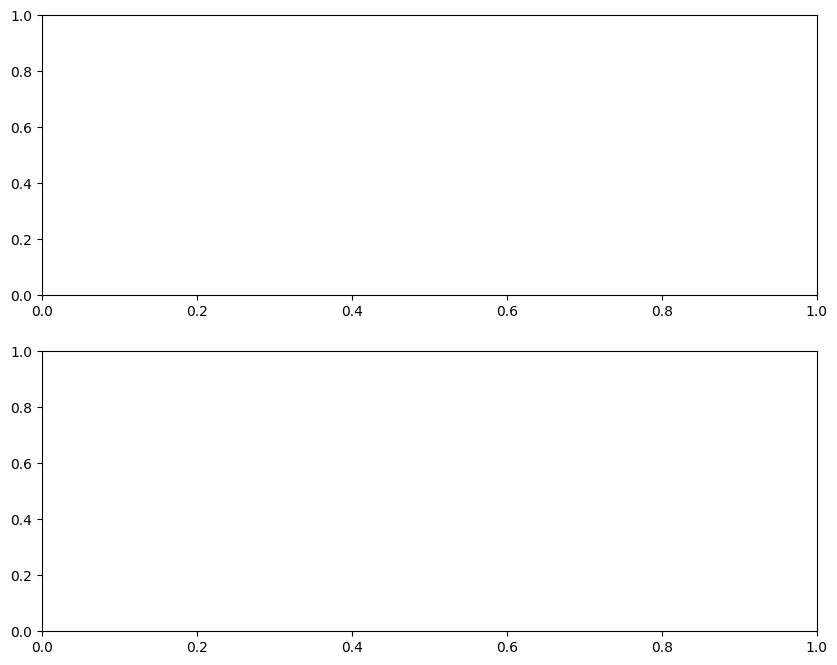

In [135]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharey=True)

X = average_sales.to_frame()
ax = X.plot(ax=ax1, title="Average Sales", ylabel="items sold")
ax.legend();

X = average_2017_sales.to_frame()
ax = X.plot(ax=ax2, title="Average 2017 Sales", ylabel="items sold")
ax.legend();

- There is a general trend in the yearly data
- Using the latest year to visualize seasonality
- Within the yearly trend there seems to be seasonality

<Axes: title={'center': 'Rolling 2017 sales'}, xlabel='date'>

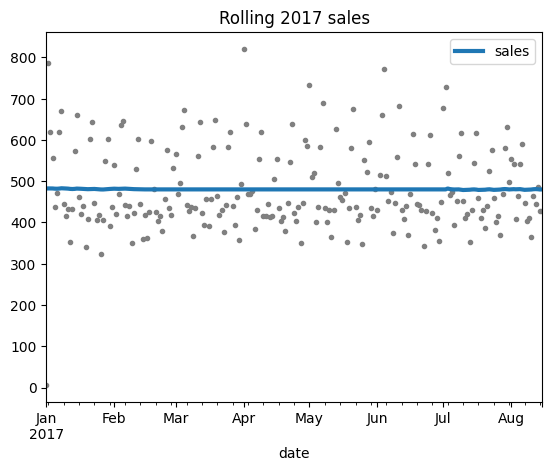

In [ ]:
trend = average_2017_sales.rolling(
    window=365,
    center=True,
    min_periods=128
).mean()

X_detrend = average_2017_sales - trend


ax = average_2017_sales.plot(style=".", color="0.5")
trend.plot(ax=ax, linewidth=3, legend=True, title="Rolling 2017 sales")

There isn't a trend in the yearly data

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

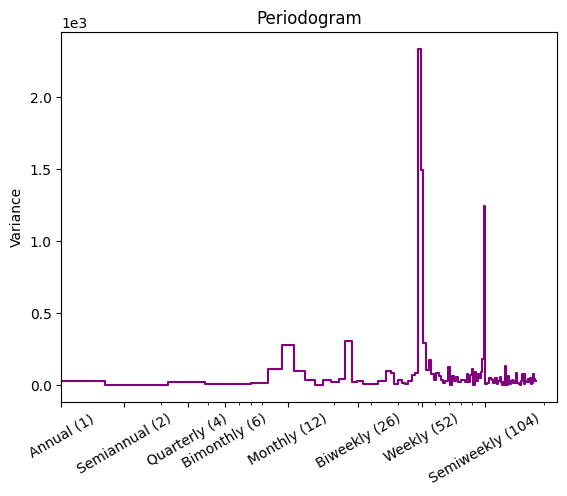

In [ ]:
plot_periodogram(average_2017_sales)

The periodgram shows mostly biweekly and weekly seasonality with hints of monthly seasonality.

c:\Python311\Lib\site-packages\learntools-0.3.4-py3.11.egg\learntools\time_series\utils.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

c:\Python311\Lib\site-packages\learntools-0.3.4-py3.11.egg\learntools\time_series\utils.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

c:\Python311\Lib\site-packages\learntools-0.3.4-py3.11.egg\learntools\time_series\utils.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.



<Axes: title={'center': 'Seasonal Plot (month/day)'}, xlabel='day', ylabel='sales'>

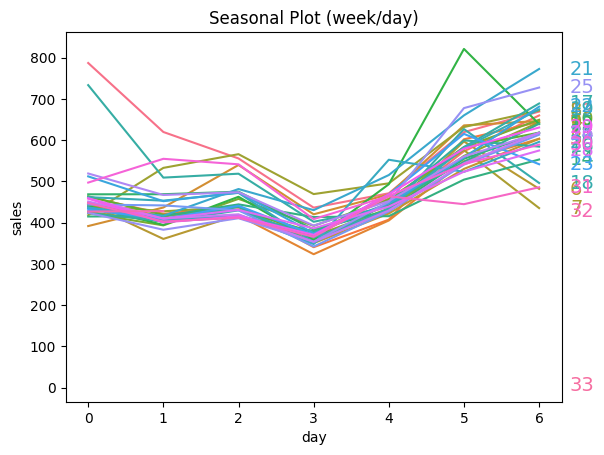

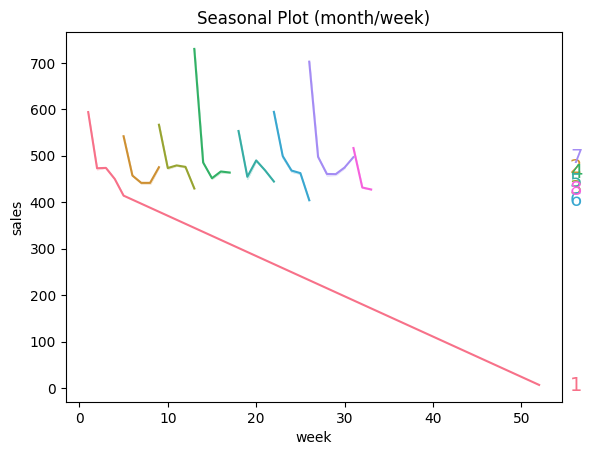

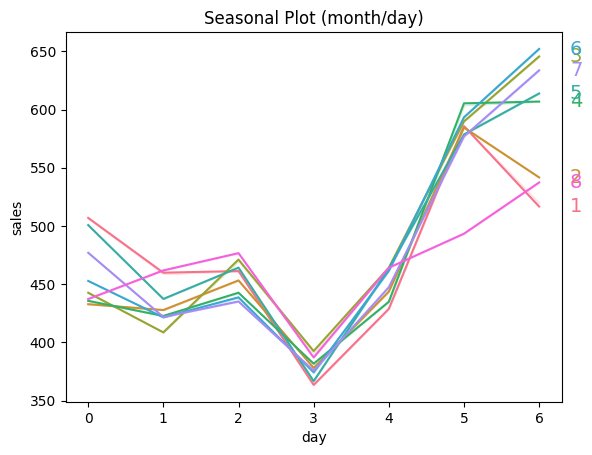

In [ ]:
X = average_2017_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
X["month"] = X.index.month
seasonal_plot(X, y="sales", period="week", freq="day")
seasonal_plot(X, y="sales", period="month", freq="week")
seasonal_plot(X, y="sales", period="month", freq="day")

The most uniform seasonality is the Weekly seasonality. There isn't an easy way to break down the biweekly seasonality to check that.

In [ ]:
y = average_2017_sales.copy()

# Quarterly seasonality
fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
    order=1,
)

X = dp.in_sample()


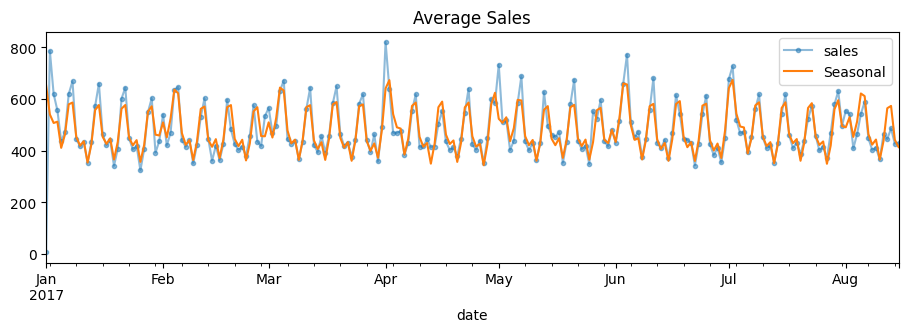

In [139]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(marker=".", alpha=0.5, title="Average Sales")
ax = y_pred.plot(ax=ax, label="Seasonal", figsize=(11, 3))
ax.legend();

Text(0.5, 1.0, 'Periodogram of Deseasoned Sales')

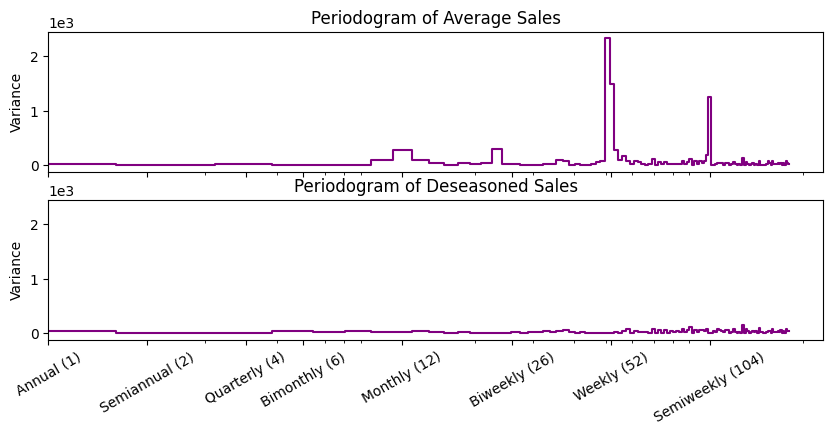

In [ ]:
deseasoned = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4), sharex=True, sharey=True)
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Periodogram of Average Sales")

ax2 = plot_periodogram(deseasoned, ax=ax2)
ax2.set_title("Periodogram of Deseasoned Sales")


Seasonality seems to be modeled well, but there are some outliers

In [ ]:
# National and regional holidays in the training set
holidays_events = pd.read_csv(
    "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-10-1', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

C:\Users\Anonymous\AppData\Local\Temp\ipykernel_3704\4187342464.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  holidays_events = pd.read_csv(


,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


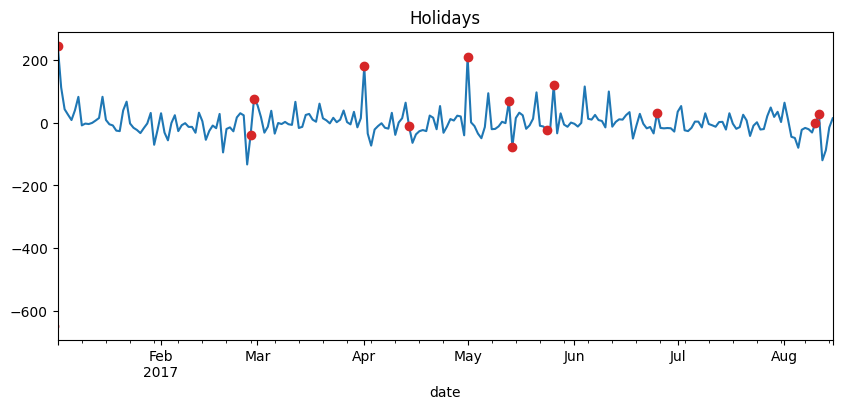

In [138]:
ax = deseasoned.iloc[1:].plot(figsize=(10, 4))
plt.plot_date(holidays.index, deseasoned[holidays.index], color='C3')
ax.set_title('Holidays');

Holidays are almost always spikes in the deseasoned data

In [ ]:
from sklearn.preprocessing import OneHotEncoder
X_holidays = pd.DataFrame(
    OneHotEncoder(sparse_output=False).fit_transform(holidays), 
    index=holidays.index,
    columns=holidays.description.unique(),
)

X2 = X.join(X_holidays, on='date').fillna(0.0)

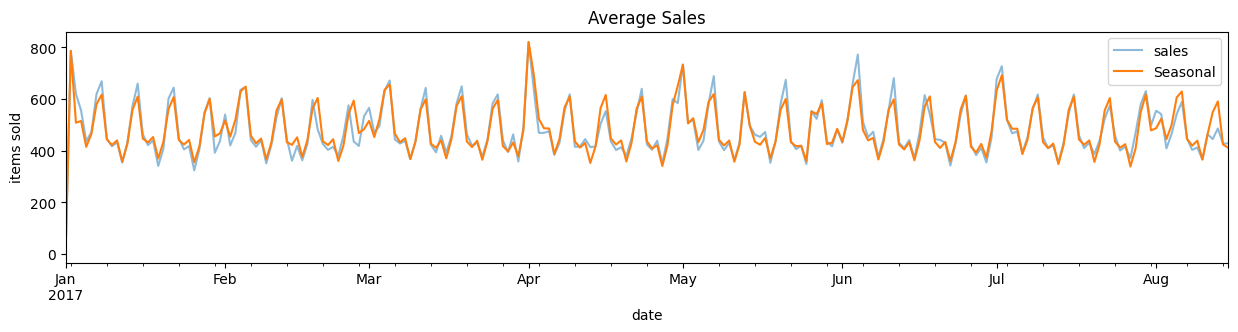

In [ ]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold", figsize=(15, 3))
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

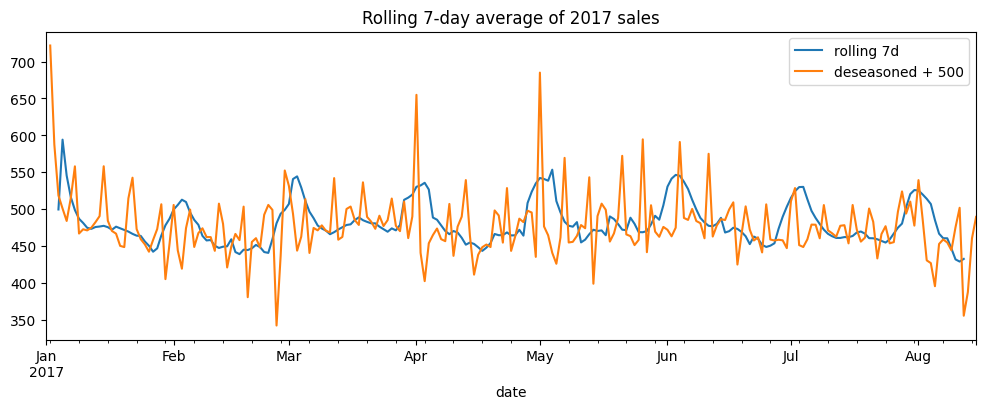

In [ ]:
rolling_7d = average_2017_sales.rolling(7, center=True).mean()
ax = rolling_7d.plot(label="rolling 7d", figsize=(12, 4))
ax.set_title("Rolling 7-day average of 2017 sales")

deseasoned.iloc[1:].add(475).plot(ax=ax, label="deseasoned + 500")
ax.legend()

- rolling 7 day is the same general shape as the deseasoned data, but the spikes are less pronounced.
- Possibility for an autocorrelation

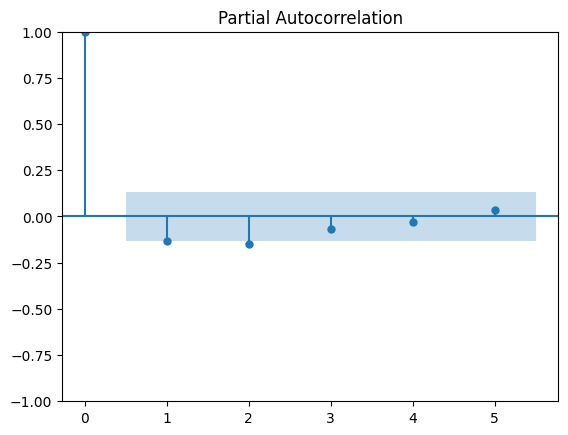

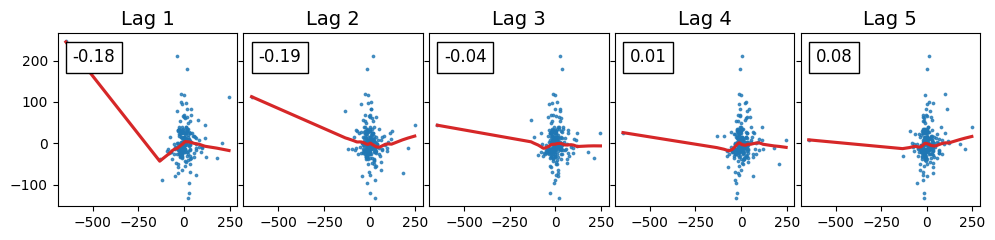

In [141]:
from statsmodels.graphics.tsaplots import plot_pacf
from learntools.time_series.utils import plot_lags, make_lags, make_leads

_ = plot_pacf(deseasoned, lags=5)
_ = plot_lags(deseasoned, lags=5)

- There appears to be a 3 day autocorrelation
- should add 3 day lag to the model

It looks like 3 lags make sense for the data

In [151]:
X_lags = make_lags(deseasoned, lags=3)


Including promotion data in the model to help get the spikes right

In [155]:
onpromotion = average_2017_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

X_promo = pd.concat([
    make_lags(onpromotion, lags=3),
    onpromotion,
    make_leads(onpromotion, leads=3).fillna(0),
], axis=1)

X = pd.concat([X_lags, X_promo], axis=1).dropna()
y, X = y.align(X, join='inner')

Training RMSLE: 0.23606
Validation RMSLE: 0.18223


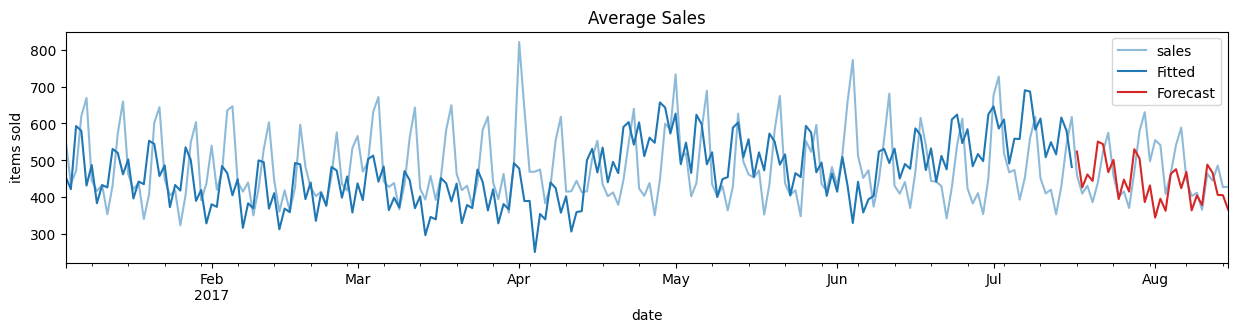

In [160]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold", figsize=(15, 3))
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();